In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
# initialize engine
engine = create_engine("sqlite:///Data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Step 1: Climate Analysis and Exploration

In [10]:
# Preview tables, columns, and data types
inspector = inspect(engine)

for table_name in inspector.get_table_names():
    print(f'Table: {table_name}')
    print('-------------')
    for column in inspector.get_columns(table_name):
        print(f"Column: {column['name']}, {column['type']}")
    print('--------------------------------------')
    print('')

Table: measurement
-------------
Column: id, INTEGER
Column: station, TEXT
Column: date, TEXT
Column: prcp, FLOAT
Column: tobs, FLOAT
--------------------------------------

Table: station
-------------
Column: id, INTEGER
Column: station, TEXT
Column: name, TEXT
Column: latitude, FLOAT
Column: longitude, FLOAT
Column: elevation, FLOAT
--------------------------------------



## Import last year precipitation data into Pandas and plot

In [58]:
# Get date of last data point
last_date = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Convert last date to datetime and subtract 1 year
first_date = dt.datetime.strptime(last_date, "('%Y-%m-%d',)") - dt.timedelta(days=366)

# Create query for pandas
pandas_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date.asc()).all()

# Sum precipitation by date and set date as index
prec_df = pd.DataFrame(pandas_query).set_index(['date'])
prec_df = prec_df.rename(columns={'prcp':'Precipitation'})

prec_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


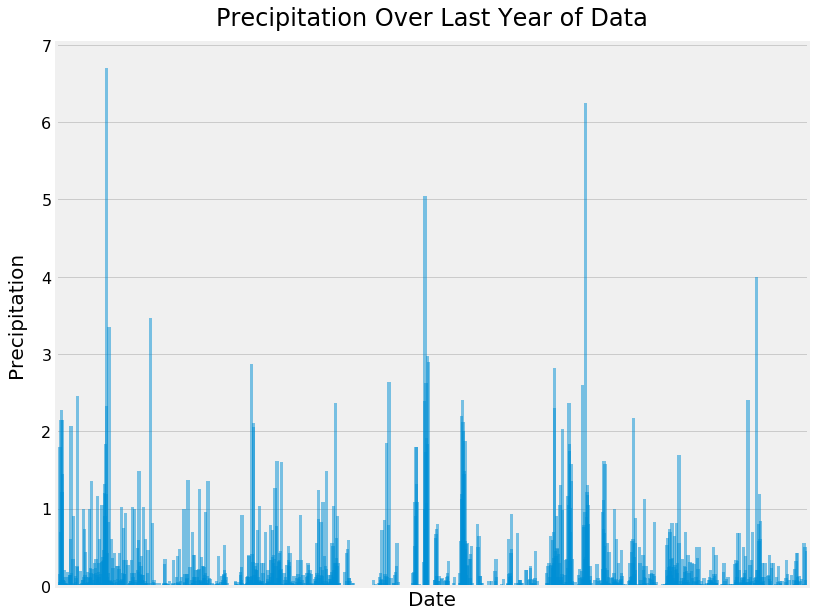

In [57]:
# Plot precipitation data
fig, ax1 = plt.subplots(figsize=(12,10))
prec_df.plot(kind='bar', ax=ax1, width=10, alpha = 0.5)

# Axis
ax1.grid(axis='x')

# Ticks
ax1.tick_params(axis='y', which='both', labelsize=16, pad=5)
my_ticks = ax1.xaxis.get_majorticklabels()
ax1.set_xticks([])

#Labels
ax1.set_xticklabels([])
ax1.set_title('Precipitation Over Last Year of Data', size=24, y = 1.02, x = 0.5)
ax1.set_xlabel("Date", fontsize = 20)
ax1.set_ylabel("Precipitation", fontsize = 20, labelpad = 15)

# Legend
ax1.get_legend().remove()

plt.show()

In [13]:
# Pandas summary statistics for the precipitation data
prec_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Import last year temperature data from the most active station into Pandas and plot

In [14]:
# Get total number of stations
session.query(Measurement).distinct(Measurement.station).\
    group_by(Measurement.station).count()

9

In [15]:
# List station activity in descending order (total row counts per station)
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Find lowest, highest, and average temperatures from the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter_by(station='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Return station with greatest number of temperature observations
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

('USC00519281', 2772)

In [18]:
# Create query for last 12 months of temperature data for station USC00519281
pandas_tobs_query = session.query(Measurement.tobs).\
    filter(Measurement.date >= first_date).\
    filter_by(station='USC00519281').all()

# Create dataframe using query
tobs_df = pd.DataFrame(pandas_tobs_query).rename(columns={'tobs':'Temperature'})

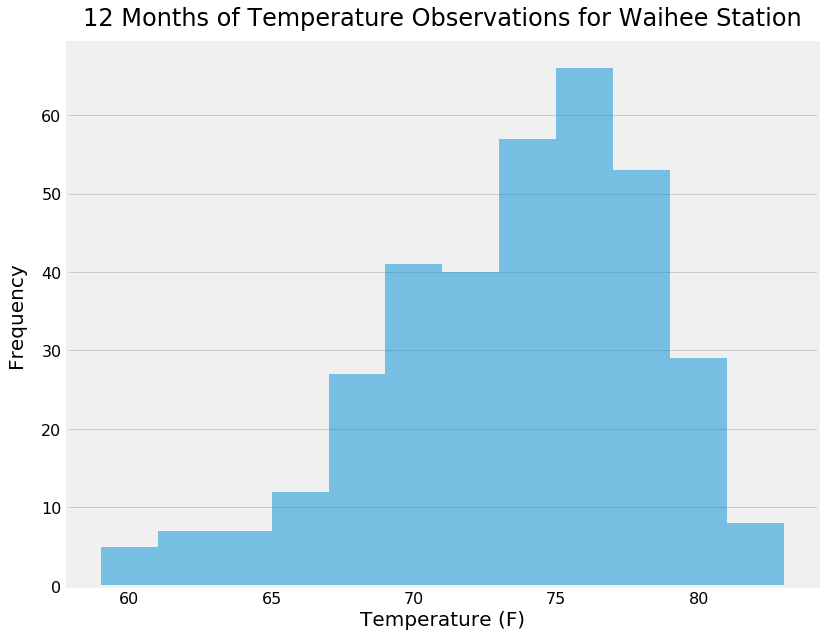

In [19]:
# Plot last 12 months of temperature data from most active temperature reading station
fig, ax1 = plt.subplots(figsize=(12,10))
tobs_df.plot(kind='hist', ax=ax1, bins=12, alpha = 0.5)

# Axis
ax1.grid(axis='x')

# Ticks
ax1.tick_params(axis='y', which='both', labelsize=16, pad=5)
ax1.tick_params(axis='x', which='both', labelsize=16, pad=5)

# Labels
ax1.set_title('12 Months of Temperature Observations for Waihee Station', size=24, y = 1.02, x = 0.5)
ax1.set_xlabel("Temperature (F)", fontsize = 20)
ax1.set_ylabel("Frequency", fontsize = 20, labelpad = 15)

# Legend
ax1.get_legend().remove()

plt.show()

# Bonus: Additional Analysis

In [20]:
# Import weather station measurement csv into pandas
measure_df = pd.read_csv('Data/hawaii_measurements.csv')

## June vs. December Temperatures

In [21]:
# Convert date column to datetime
measure_df['date'] = pd.to_datetime(measure_df['date'])

# Create june and december dataframes
june_df = measure_df.loc[measure_df['date'].dt.month==6]
dec_df = measure_df.loc[measure_df['date'].dt.month==12]

# Calculate averages and display
june_temp_avg = round(june_df['tobs'].mean(), 1)
dec_temp_avg = round(dec_df['tobs'].mean(), 1)

print(f'''
    Average Temperatures:
    June: {june_temp_avg}
    December: {dec_temp_avg}
    ''')


    Average Temperatures:
    June: 74.9
    December: 71.0
    


In [22]:
import scipy.stats as stats
june_desc = stats.describe(june_df.tobs)
dec_desc = stats.describe(dec_df.tobs)
levene = stats.levene(june_df.tobs, dec_df.tobs)
ttest = stats.ttest_ind(june_df.tobs, dec_df.tobs, equal_var=False)

print(f'''
    June Temperature Stats Summary:
        {june_desc}
        
    December Temperature Stats Summary:
        {dec_desc}
        
    Levene test shows variances are not equal:
        {levene}
        
    Independent t-test assuming unequal variance, shows that the means are statistically different:
        {ttest}
    ''')


    June Temperature Stats Summary:
        DescribeResult(nobs=1700, minmax=(64, 85), mean=74.94411764705882, variance=10.610765848422947, skewness=-0.2258766702189613, kurtosis=-0.4229534222260054)
        
    December Temperature Stats Summary:
        DescribeResult(nobs=1517, minmax=(56, 83), mean=71.04152933421226, variance=14.031915337694345, skewness=-0.4050972954211533, kurtosis=0.45781715568357617)
        
    Levene test shows variances are not equal:
        LeveneResult(statistic=11.486485455366319, pvalue=0.0007094853311953783)
        
    Independent t-test assuming unequal variance, shows that the means are statistically different:
        Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)
    


* Unpaired (independent) t-test used due to Levene test showing unequal variances
    * Addtionally, there are not the same number of data points and the data can be from different stations
* The mean temperature difference between June and December is statistically significant

## Temperature During Planned Trip
    * Trip is planned 2018-05-20 to 2018-05-30

In [23]:
# Function to return temperature min, max, and avg for date range input

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a date range.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [24]:
# Temperature stats during time of planned trip for the previous year
trip_start = '2017-05-20'
trip_end = '2017-05-30'
temp_trip_df = calc_temps(trip_start, trip_end)
temp_trip_df

[(69.0, 75.23809523809524, 87.0)]

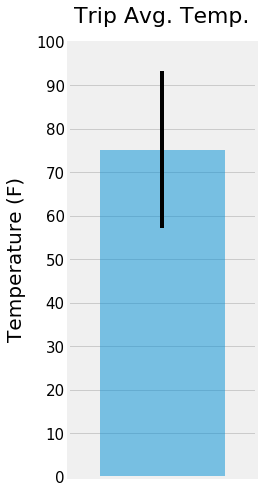

In [42]:
# Plot tempurature stats
fig, ax1 = plt.subplots(figsize=(3,8))

ax1.bar(0, temp_trip_df[0][1], yerr=temp_trip_df[0][2]-temp_trip_df[0][0], alpha=0.5)
ax1.set_xlim(-0.6, 0.6)
ax1.grid(axis='x')

# Labels
ax1.set_xticklabels([])
ax1.set_yticks(range(0,110,10))
ax1.tick_params(axis='both', which='both', labelsize=15)
ax1.set_title('Trip Avg. Temp.', size=22, y = 1.03) 
ax1.set_ylabel("Temperature (F)", fontsize = 20, labelpad = 10)

plt.show()

## Daily Rainfall Average
    * Analyse possible rainfall during planned trip dates

In [26]:
# Calculate the rainfall per weather station using the previous year's matching dates
trip_prcp = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.29),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.25),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.5),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.2700000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.65),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.35000000000000003)]

## Trip Daily Temperature Normals
    * Plot the daily min, max, and avg temperature for each day of the trip

In [27]:
# Function to strip year from dates and return a list of each day

def range_to_days(start, end):
    '''
    Args: 
        start/end: 'yyyy-mm-dd' format
    
    Returns:
        List of days in the formats 'mm-dd'
    '''
    
    day_list =[]
    start_date = dt.datetime.strptime(start, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end, "%Y-%m-%d")
    start_day = start_date.day
    
    while start_day <= end_date.day:
        day_list.append(f'0{start_date.month}-{start_day}')
        start_day += 1
                        
    return day_list

In [28]:
# Query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime('%m-%d', Measurement.date) == date).all()

In [29]:
# Get list of days of trip in mm-dd format
trip_days = range_to_days(trip_start, trip_end)

# Append daily normals for tip days into normals list
normals=[]
for x in trip_days:
    normals.append(daily_normals(x)[0])
    
# Print list containg temperature normals for each day
print(normals)

[(68.0, 73.89655172413794, 79.0), (64.0, 72.96428571428571, 80.0), (64.0, 74.45614035087719, 80.0), (68.0, 74.94827586206897, 87.0), (67.0, 73.94827586206897, 79.0), (68.0, 74.27586206896552, 79.0), (65.0, 74.03636363636363, 82.0), (65.0, 74.49090909090908, 80.0), (67.0, 74.27777777777777, 82.0), (64.0, 74.19607843137256, 80.0), (69.0, 74.33333333333333, 81.0)]


In [30]:
# Convert dates to pandas datetime and then to python datetime for matplotlib plotting
index = pd.date_range(start = trip_start, end = trip_end, freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in index]

# Create pandas datafreame using normals list and converted dates
trip_normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=index)

trip_normals_df

,tmin,tavg,tmax
2017-05-20,68.0,73.896552,79.0
2017-05-21,64.0,72.964286,80.0
2017-05-22,64.0,74.456140,80.0
2017-05-23,68.0,74.948276,87.0
2017-05-24,67.0,73.948276,79.0
2017-05-25,68.0,74.275862,79.0
2017-05-26,65.0,74.036364,82.0
2017-05-27,65.0,74.490909,80.0
2017-05-28,67.0,74.277778,82.0
2017-05-29,64.0,74.196078,80.0


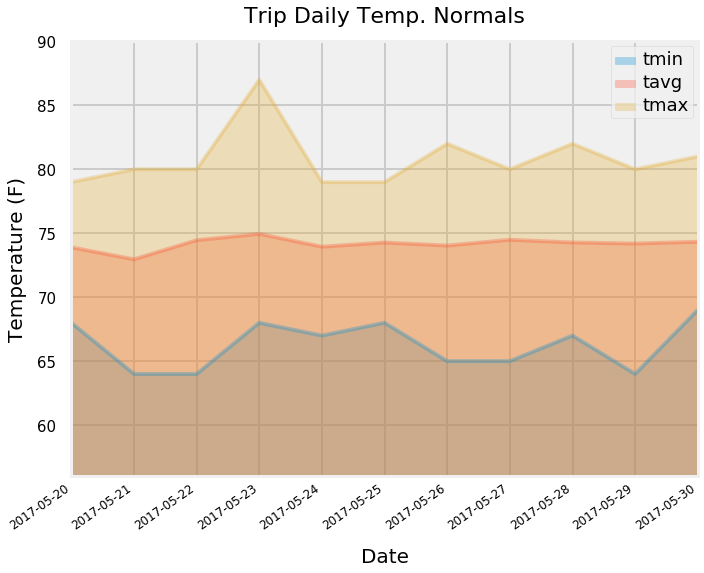

In [31]:
# Plot unstacked areas of trip_normals_df
fig, ax1 = plt.subplots(figsize=(10,8))
trip_normals_df.plot.area(ax=ax1, stacked=False, alpha=0.3)

# Axis
ax1.set_ylim(56, 90)
ax1.grid(which='both', axis='both' , linestyle='-', linewidth=2)

# Ticks
ax1.tick_params(axis='x', which='both', labelsize=12, pad=5, rotation=35)
ax1.tick_params(axis='y', which='both', labelsize=15, pad=15)
plt.setp( ax1.xaxis.get_majorticklabels(), ha="right" )

# Axis Labels
ax1.set_title('Trip Daily Temp. Normals', size=22, y = 1.03) 
ax1.set_ylabel("Temperature (F)", fontsize = 20, labelpad = 10)
ax1.set_xlabel("Date", fontsize = 20, labelpad = 15)

# Legend
plt.setp(ax1.get_legend().get_texts(), fontsize='18')

plt.show()